<a href="https://colab.research.google.com/github/poliduckie/poliduckie_segmentation/blob/master/examples/MPC_with_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os 
branch = "daffy" #@param ['master', 'daffy']
if branch == "daffy":
  !pip install duckietown-gym-daffy
else:
  if not os.path.isdir('gym-duckietown') and not os.path.isdir('../gym-duckietown'):
    !git clone --branch {branch} https://github.com/duckietown/gym-duckietown.git
    !pip3 install -e gym-duckietown
  if "/gym-duckietown" not in os.getcwd():
    os.chdir('gym-duckietown')
!apt install xvfb -y
!pip3 install pyvirtualdisplay

from pyvirtualdisplay import Display
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
%matplotlib inline

## used to copy the model to the gdrive folder
import shutil

import cv2
import gym
import gym_duckietown

!pip install poliduckie-segmentation==0.1.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.11).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 28 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


DEBUG:commons:version: 6.2.4 *
DEBUG:typing:version: 6.2.3
DEBUG:duckietown_world:duckietown-world version 6.2.39 path /usr/local/lib/python3.7/dist-packages
DEBUG:geometry:PyGeometry-z6 version 2.1.4 path /usr/local/lib/python3.7/dist-packages
DEBUG:aido_schemas:aido-protocols version 6.0.59 path /usr/local/lib/python3.7/dist-packages
DEBUG:nodes:version 6.2.13 path /usr/local/lib/python3.7/dist-packages pyparsing 3.0.9
DEBUG:gym-duckietown:gym-duckietown version 6.1.30 path /usr/local/lib/python3.7/dist-packages



{'audio': ('xaudio2', 'directsound', 'openal', 'pulse', 'silent'), 'debug_font': False, 'debug_gl': True, 'debug_gl_trace': False, 'debug_gl_trace_args': False, 'debug_graphics_batch': False, 'debug_lib': False, 'debug_media': False, 'debug_texture': False, 'debug_trace': False, 'debug_trace_args': False, 'debug_trace_depth': 1, 'debug_trace_flush': True, 'debug_win32': False, 'debug_x11': False, 'graphics_vbo': True, 'shadow_window': True, 'vsync': None, 'xsync': True, 'xlib_fullscreen_override_redirect': False, 'darwin_cocoa': True, 'search_local_libs': True, 'advanced_font_features': False, 'headless': False, 'headless_device': 0, 'win32_disable_shaping': False}
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.2 MB 1.8 MB/s 
  Attempting uninstall: poliduckie-segmentation
    Found existing installation: poliduckie-segmentation 0.1.5
    Uninstalling poliduckie-segmentation-0.1.5:
      Succ

In [2]:
# Gym has a built in logger to log information. The information is split in importance levels, from highest to lowest:
# CRITICAL, ERROR, WARNING, INFO, DEBUG, NOTSET
# To stop gym from printing many verbose NOTSET, INFO and DEBUG messages we let it print only level WARNING or higher messages
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

In [3]:
map_name = "Duckietown-zigzag_dists-v0"

In [4]:
display = Display(visible=0, size=(1400, 900))
display.start()
env = gym.make(map_name)

INFO:duckietown_world: data: /usr/local/lib/python3.7/dist-packages/duckietown_world/data
/usr/local/lib/python3.7/dist-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


(480, 640, 3)


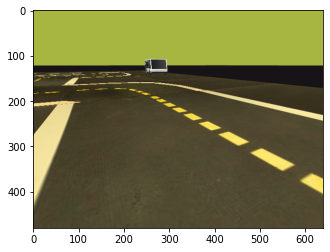

In [5]:
img_example = env.reset()
plt.imshow(img_example)
print(img_example.shape)

In [6]:
from poliduckie_segmentation import Segmentation

segmentation = Segmentation()
prediction = segmentation.predict(cv2.resize(img_example,(320,240),interpolation=cv2.INTER_CUBIC))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 240, 320, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 240, 320, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

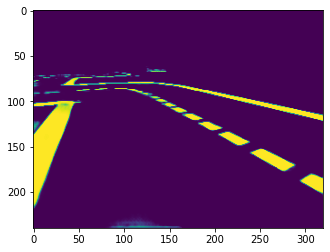

In [7]:
prediction_reshaped = np.reshape(prediction, (240, 320))
plt.imshow(prediction_reshaped)

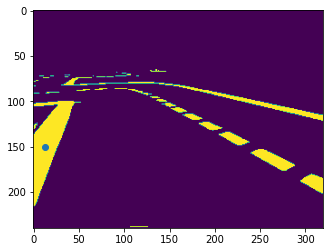

In [8]:
prediction_rounded = np.around(prediction_reshaped)

y = 150
x = np.argwhere(prediction_rounded[y]).mean()

plt.scatter(x,y)
plt.imshow(prediction_rounded)

In [9]:
lane_width = 0.445 # m
x_factor = lane_width/prediction_rounded.shape[1] # m/px
x_factor

0.001390625

In [10]:
x_cm = x*x_factor
y_cm = 0.1 # m, needs to be tuned

In [11]:
def get_reference_from_segmentation(img, x_factor=0.00139, y_cm=0.1, N=10):
  y = 150
  x = np.argwhere(prediction_rounded[y]).mean()
  x_cm = x*x_factor
  return np.array([[x_cm, y_cm]]*N).T

In [12]:
from poliduckie_segmentation.control import MPC
M = MPC()

In [13]:
r = get_reference_from_segmentation(prediction_rounded, N=11)

f"Reference is {r[0, 0], r[1,0]}"

'Reference is (0.01807, 0.1)'

In [32]:
from poliduckie_segmentation.model import Model

# State X = [x, y, angle, longitudinal speed, angular speed]
X = [0,0,0,0,0]

F = Model()
input_list = []
positions = []

counter = 0

while np.square(X[0]-r[0,0]) + np.square(X[1]-r[1,0]) > 0.001 and counter < 20:
  action = M.mpc(X, r)
  if counter > 0:
    state = X.toarray().T[0]
  else:
    state = X
  X = F.step(*state, action)
  input_list.append(action)
  positions.append(X[:2])

  counter += 1

input_list = np.array(input_list)
positions = np.array(positions)

In [33]:
input_list

array([[ 0.        , 19.10767173],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 0.75      ,  4.77691793],
       [ 1.        ,  0.        ],
       [ 0.        , 19.10767173],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 1.        ,  0.        ],
       [ 0.335     , 12.7066017 ],
       [ 0.        , 19.10767173]])

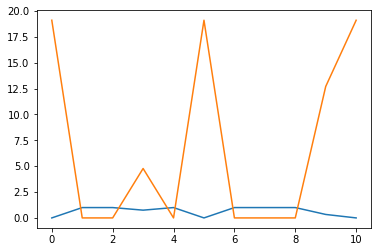

In [34]:
plt.plot(input_list)

In [35]:
positions.reshape(-1,2)

array([[0.        , 0.        ],
       [0.        , 0.        ],
       [0.00267977, 0.00198241],
       [0.00728806, 0.00599606],
       [0.01259878, 0.01142226],
       [0.01685446, 0.02009488],
       [0.01795967, 0.02806906],
       [0.0193383 , 0.03801599],
       [0.02094477, 0.04960687],
       [0.01997666, 0.06265573],
       [0.01314678, 0.07254753]])

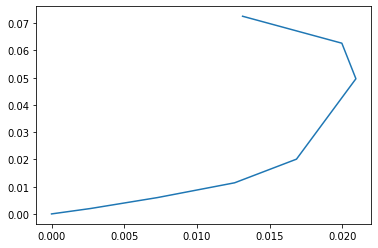

In [36]:
plt.plot(*positions.reshape(-1, 2).T)